# Best Predictor to Determine Song Popularity

The goal of this project will be to determine what features of a song is the best predictor for it's popularity. This notebook will be in multiple parts. The data analysis completed on this project will be as follows.

1) Data cleaning removing any duplicates
2) Dropping unneccesary data
3) Create a correlation matrix for the data
4) Create a pairplot of the data
5) Splitting data into test and train
5) Run linear regression models on each feature and report R-squared values
6) Determine the best predictor for song popularity based on linear regression models
7) Run a multilinear models to also determine best predictor for song popularity 
8) Going to run KNN and Decision Trees on a simplified version of the problem - genre vs popularity
9) Create a confusion matrix for KNN model and Decision Tree
10) Calculate percentages for genre and popularity
11) Finally a summary that can describe what features have the biggest impact on song popularity

In [89]:
import scipy as sp
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

## EDA
data cleaning, removing duplicates and data visualization

In [52]:
#Data Cleaning and removing song duplicates
df = pd.read_csv('spotify__song_popularity_prediction.csv')
dfCleaned=df.drop_duplicates(subset='track_id', keep='first')

In [53]:
dfCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89741 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        89741 non-null  int64  
 1   track_id          89741 non-null  object 
 2   artists           89740 non-null  object 
 3   album_name        89740 non-null  object 
 4   track_name        89740 non-null  object 
 5   popularity        89741 non-null  int64  
 6   duration_ms       89741 non-null  int64  
 7   explicit          89741 non-null  bool   
 8   danceability      89741 non-null  float64
 9   energy            89741 non-null  float64
 10  key               89741 non-null  int64  
 11  loudness          89741 non-null  float64
 12  mode              89741 non-null  int64  
 13  speechiness       89741 non-null  float64
 14  acousticness      89741 non-null  float64
 15  instrumentalness  89741 non-null  float64
 16  liveness          89741 non-null  float64
 1

In [54]:
dfCleaned.head()

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

In [55]:
#Dropping columns unneccesary multilinear regression and linear regression models
Reg_DF = dfCleaned.drop (['Unnamed: 0','explicit','track_id', 'track_name', 'artists', 'album_name'], axis=1)
#Since I want to keep track genre and it is a string I am going to factorize it
Reg_DF['genre'], _ = pd.factorize(Reg_DF['track_genre'])
Reg_DF.drop('track_genre', axis=1, inplace=True)
#Some of the acousticness data is in scientific notation so convert those to numeric
Reg_DF['acousticness'] = pd.to_numeric(Reg_DF['acousticness'])


#Dropping all columns except genre and popularity for KNN and Decision Tree
IntDF=dfCleaned.drop (['Unnamed: 0','explicit','track_id', 'track_name', 'artists', 'album_name'], axis=1)
IntDF['popular'] = np.where(IntDF['popularity'] >= 50, 1,0)
IntDF['genre'], _ = pd.factorize(IntDF['track_genre'])
KNN_DT_DF = IntDF[['popular','genre']]



In [56]:
KNN_DT_DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89741 entries, 0 to 113999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   popular  89741 non-null  int64
 1   genre    89741 non-null  int64
dtypes: int64(2)
memory usage: 2.1 MB


In [57]:
Reg_DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89741 entries, 0 to 113999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        89741 non-null  int64  
 1   duration_ms       89741 non-null  int64  
 2   danceability      89741 non-null  float64
 3   energy            89741 non-null  float64
 4   key               89741 non-null  int64  
 5   loudness          89741 non-null  float64
 6   mode              89741 non-null  int64  
 7   speechiness       89741 non-null  float64
 8   acousticness      89741 non-null  float64
 9   instrumentalness  89741 non-null  float64
 10  liveness          89741 non-null  float64
 11  valence           89741 non-null  float64
 12  tempo             89741 non-null  float64
 13  time_signature    89741 non-null  int64  
 14  genre             89741 non-null  int64  
dtypes: float64(9), int64(6)
memory usage: 11.0 MB


In [20]:
#Creating correlation matrix
Reg_DF.corr()

popularity  duration_ms  danceability    energy       key  \
popularity          1.000000    -0.023119      0.064281  0.013728  0.003432   
duration_ms        -0.023119     1.000000     -0.064130  0.063261  0.011286   
danceability        0.064281    -0.064130      1.000000  0.143914  0.035114   
energy              0.013728     0.063261      0.143914  1.000000  0.046334   
key                 0.003432     0.011286      0.035114  0.046334  1.000000   
loudness            0.071676     0.000364      0.271839  0.758774  0.035902   
mode               -0.016214    -0.039347     -0.062633 -0.075014 -0.142096   
speechiness        -0.047081    -0.060744      0.109520  0.141332  0.017759   
acousticness       -0.038847    -0.108499     -0.177043 -0.732566 -0.045159   
instrumentalness   -0.127465     0.117381     -0.194747 -0.181037 -0.005284   
liveness           -0.013844     0.008126     -0.132234  0.188941 -0.002584   
valence            -0.011526    -0.147037      0.492571  0.256313  0.026258   
tempo               0.007270     0.025991     -0.021331  0.258628  0.008275   
time_signature      0.036893     0.022602      0.210041  0.186534  0.014801   
genre               0.036906    -0.029347     -0.026635 -0.061787 -0.009155   

                  loudness      mode  speechiness  acousticness  \
popularity        0.071676 -0.016214    -0.047081     -0.038847   
duration_ms       0.000364 -0.039347    -0.060744     -0.108499   
danceability      0.271839 -0.062633     0.109520     -0.177043   
energy            0.758774 -0.075014     0.141332     -0.732566   
key               0.035902 -0.142096     0.017759     -0.045159   
loudness          1.000000 -0.037108     0.055295     -0.582663   
mode             -0.037108  1.000000    -0.040798      0.091020   
speechiness       0.055295 -0.040798     1.000000      0.005121   
acousticness     -0.582663  0.091020     0.005121      1.000000   
instrumentalness -0.434717 -0.052580    -0.099658      0.096065   
liveness          0.077239  0.016777     0.225102     -0.019081   
valence           0.289091  0.025568     0.032932     -0.103767   
tempo             0.228659 -0.001903     0.004032     -0.220244   
time_signature    0.193695 -0.023903    -0.006198     -0.174054   
genre            -0.043471 -0.005809    -0.087138      0.087524   

                  instrumentalness  liveness   valence     tempo  \
popularity               -0.127465 -0.013844 -0.011526  0.007270   
duration_ms               0.117381  0.008126 -0.147037  0.025991   
danceability             -0.194747 -0.132234  0.492571 -0.021331   
energy                   -0.181037  0.188941  0.256313  0.258628   
key                      -0.005284 -0.002584  0.026258  0.008275   
loudness                 -0.434717  0.077239  0.289091  0.228659   
mode                     -0.052580  0.016777  0.025568 -0.001903   
speechiness              -0.099658  0.225102  0.032932  0.004032   
acousticness              0.096065 -0.019081 -0.103767 -0.220244   
instrumentalness          1.000000 -0.087152 -0.330759 -0.056888   
liveness                 -0.087152  1.000000  0.012314 -0.006117   
valence                  -0.330759  0.012314  1.000000  0.090622   
tempo                    -0.056888 -0.006117  0.090622  1.000000   
time_signature           -0.082237 -0.030787  0.135525  0.085456   
genre                    -0.049612  0.048673  0.035306 -0.032281   

                  time_signature     genre  
popularity              0.036893  0.036906  
duration_ms             0.022602 -0.029347  
danceability            0.210041 -0.026635  
energy                  0.186534 -0.061787  
key                     0.014801 -0.009155  
loudness                0.193695 -0.043471  
mode                   -0.023903 -0.005809  
speechiness            -0.006198 -0.087138  
acousticness           -0.174054  0.087524  
instrumentalness       -0.082237 -0.049612  
liveness               -0.030787  0.048673  
valence                 0.135525  0.035306  
tempo 

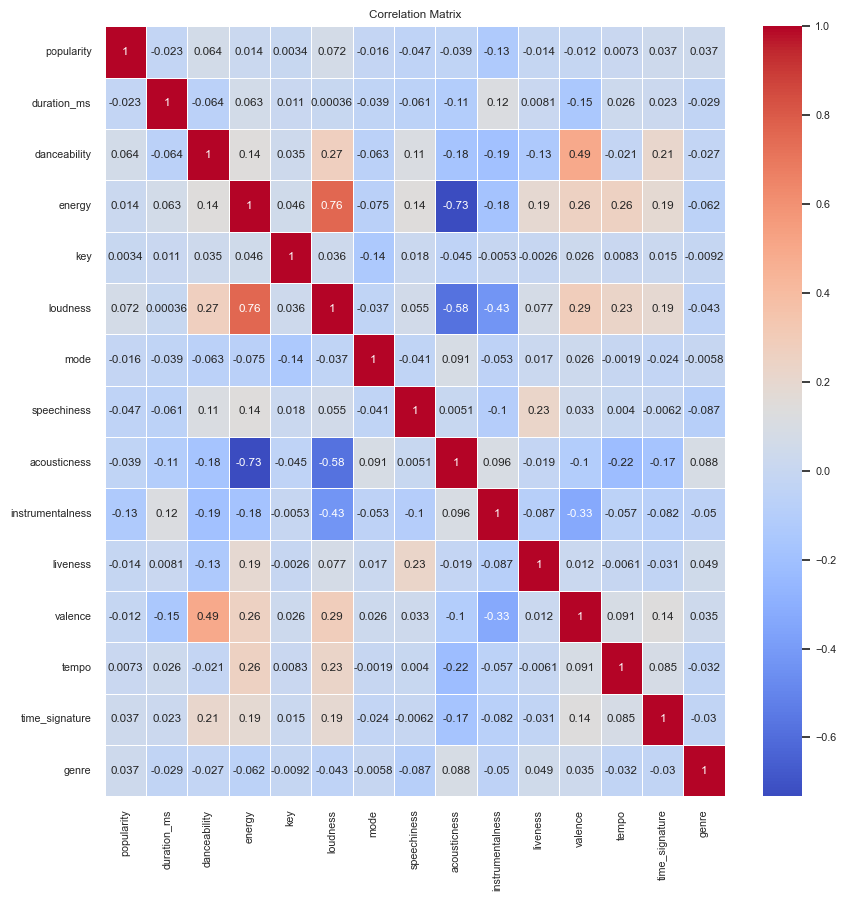

In [21]:
#Plotting correlation matrix
sns.set(font_scale=.7)
plt.figure(figsize=(10, 10))
plt.title('Correlation Matrix')
sns.heatmap(Reg_DF.corr(), annot=True, linewidth=.5, cmap='coolwarm')
plt.show()

Based on correlation matrix loudness is the predictor with the strongest relationship with song popularity

/Users/r/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x2000 with 0 Axes>

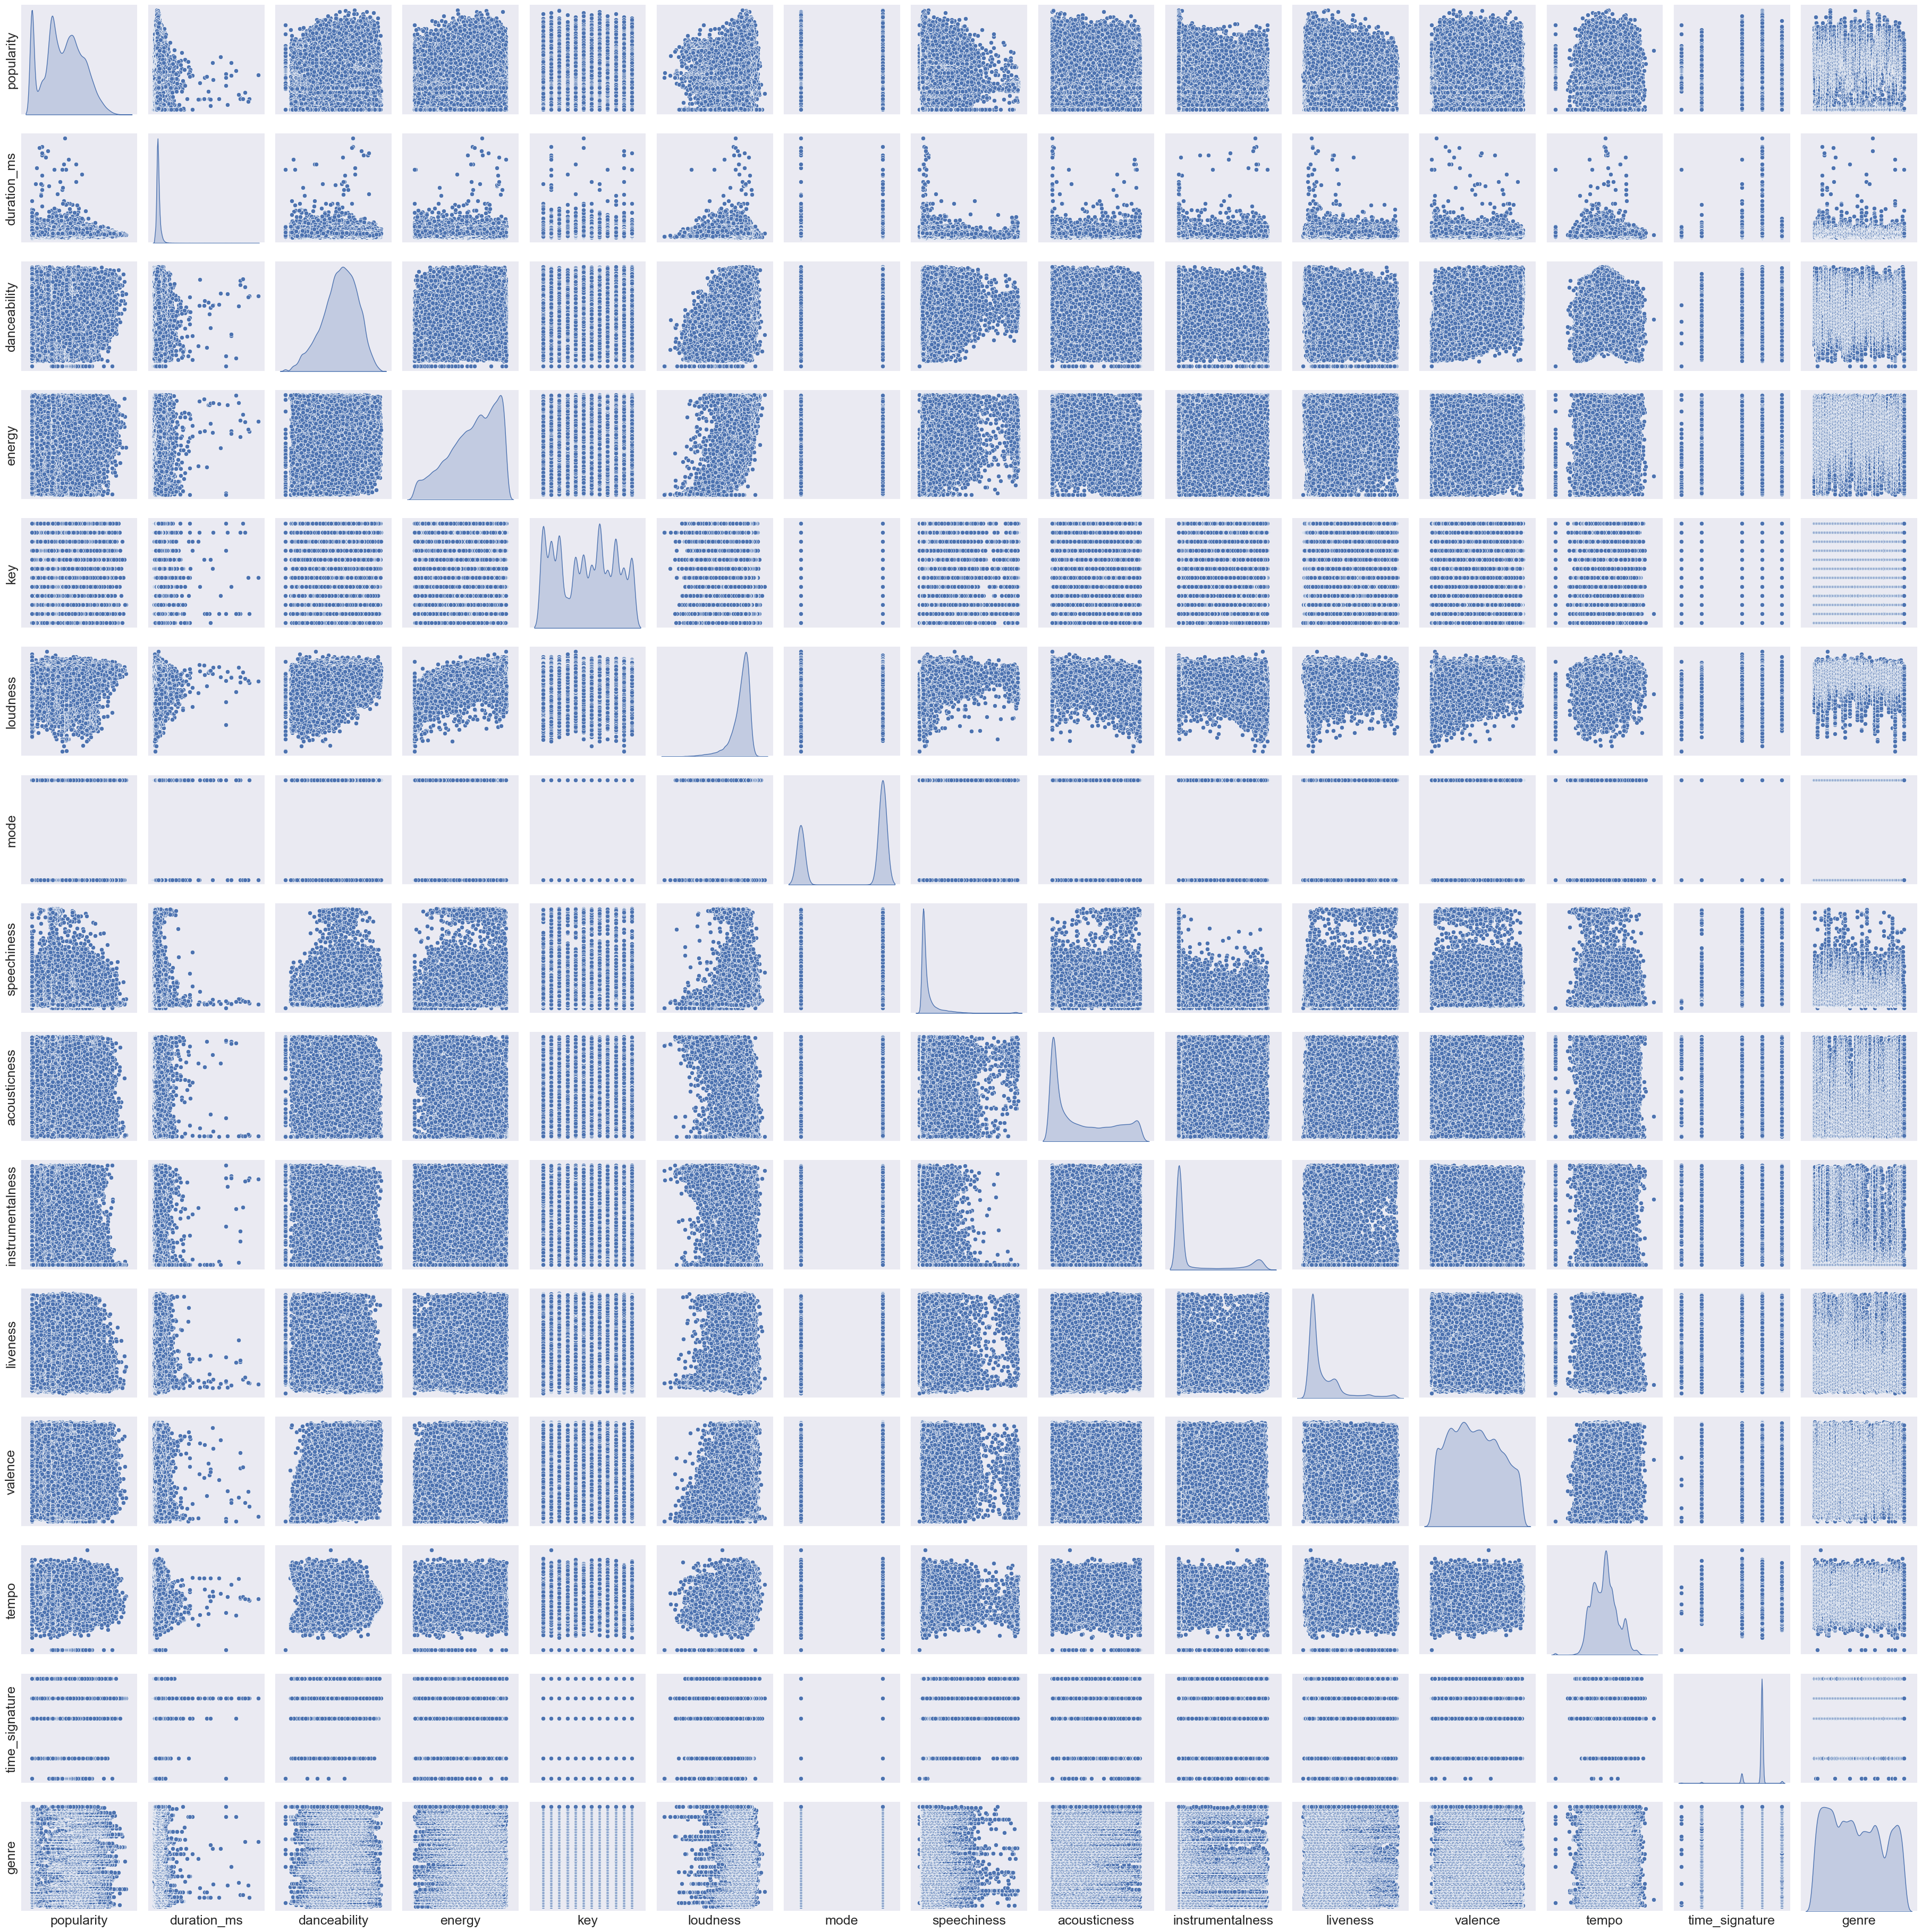

In [22]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 20))
plt.title
pairPlot=sns.pairplot(Reg_DF, diag_kind="kde")
axes=pairPlot.axes.flatten()
for axis in axes:
    axis.set_xticklabels([])
    axis.set_yticklabels([])
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()



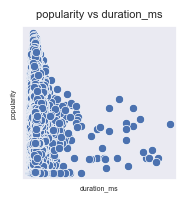

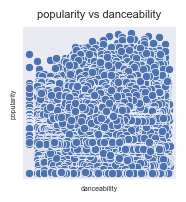

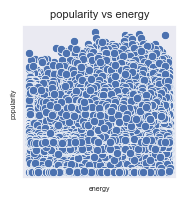

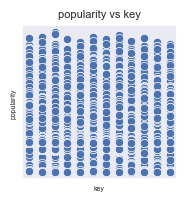

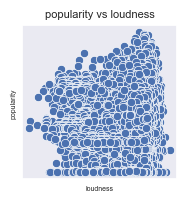

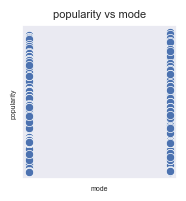

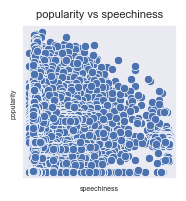

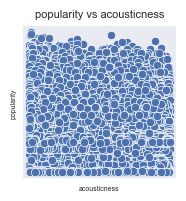

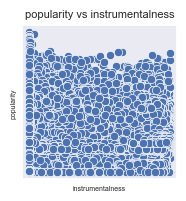

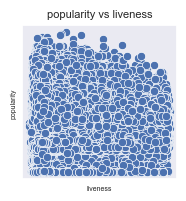

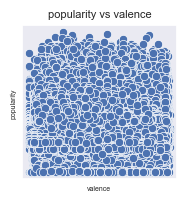

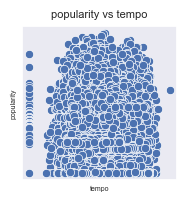

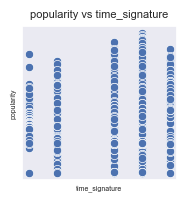

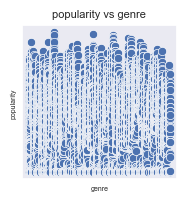

In [23]:
#Closer view of pair plots vs popularity
features = Reg_DF.drop('popularity', axis =1)

for feature in features:
    plt.figure(figsize=(2,2))
    
    sns.scatterplot(data=Reg_DF, x= feature, y='popularity')
    plt.title(f'popularity vs {feature}', fontsize=8)
    plt.xlabel(feature, fontsize=5)
    plt.ylabel('popularity', fontsize=5)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.show()

In [24]:
#Splitting data into testing and training for simple linear regression 

X = Reg_DF.drop('popularity', axis=1)
y = Reg_DF['popularity']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=42)

train, test = train_test_split(Reg_DF, test_size = 0.20, random_state=42)

## Linear Regression Models

In [25]:
# #Going to run models on each feature to determine best predictor

adjustedRValues={}

for predictor in train.columns:
    formula = f'popularity ~ {predictor}'
    model = smf.ols(formula=formula, data=train).fit()
    adjustedRValues[predictor] = model.rsquared_adj

sortedPredictors = sorted(adjustedRValues.items(), key=lambda x: x[1], reverse=True)
sortedPredictors   


[('popularity', 1.0),
 ('instrumentalness', 0.016184883456534127),
 ('loudness', 0.004927540518448015),
 ('danceability', 0.004105810570775303),
 ('speechiness', 0.002257122479505602),
 ('acousticness', 0.0016548159091672732),
 ('genre', 0.0014020510909312778),
 ('time_signature', 0.0013403967307838993),
 ('duration_ms', 0.0004743628996903837),
 ('mode', 0.00029539566355207825),
 ('liveness', 0.00020951577837302615),
 ('valence', 0.0001952584019994097),
 ('energy', 0.00016670132697260698),
 ('tempo', 3.7473511832586404e-05),
 ('key', -5.184757076781565e-06)]

Based on our data, instrumentalness was the greatest predictor if a song was to be popular or not. However, there is little correlation between any of the features and song popularity

In [26]:
# #Now going to determine how well this model performs

Xtrain_instrumentalness = sm.add_constant(X_train[['instrumentalness']])
Xtest_instrumentalness = sm.add_constant(X_test[['instrumentalness']])

instrumentalnessModel = sm.OLS(y_train, Xtrain_instrumentalness).fit()
y_pred = instrumentalnessModel.predict(Xtest_instrumentalness)

meanAbsErr = mean_absolute_error(y_test, y_pred)
meanSqErr = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(meanSqErr)
rSq = r2_score(y_test,y_pred)

print(f"Mean Absolute Error: {meanAbsErr}")
print(f"Mean Squared Error: {meanSqErr}")
print(f"Root Mean Square Error: {RMSE}")
print(f"R-Squared: {rSq}")

Mean Absolute Error: 16.893541569418108
Mean Squared Error: 410.8553515474514
Root Mean Square Error: 20.26956712777684
R-Squared: 0.01636454455981784


## Multilinear Regression Models

In [27]:
#Going to see if any features are not statistically significant at a 95% confidence level
editedDF = Reg_DF.drop(columns=['popularity']) 

formula = 'popularity ~ ' + '+'.join(editedDF)
    
model = smf.ols(formula=formula,data = Reg_DF).fit()

model.summary()
#key, liveness are statistically insignificant so remove them

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     215.1
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:50:10   Log-Likelihood:            -3.9726e+05
No. Observations:               89741   AIC:                         7.946e+05
Df Residuals:                   89726   BIC:                         7.947e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           33.4526      0.891     37.554      0.000      31.707      35.199
duration_ms       -4.08e-06   6.14e-07     -6.646      0.000   -5.28e-06   -2.88e-06
danceability         9.8353      0.479     20.547      0.000       8.897      10.774
energy              -2.4279      0.544     -4.466      0.000      -3.494      -1.362
key                  0.0041      0.019      0.213      0.831      -0.034       0.042
loudness             0.0963      0.023      4.115      0.000       0.050       0.142
mode                -0.7336      0.143     -5.112      0.000      -1.015      -0.452
speechiness        -11.5640      0.642    -18.004      0.000     -12.823     -10.305
acousticness        -1.7019      0.311     -5.472      0.000      -2.311      -1.092
instrumentalness    -8.8458      0.253    -34.899      0.000      -9.343      -8.349
liveness             0.3856      0.374      1.031      0.303      -0.347       1.119
valence             -8.3346      0.325    -25.608      0.000      -8.972      -7.697
tempo                0.0049      0.002      2.084      0.037       0.000       0.010
time_signature       0.8327      0.155      5.369      0.000       0.529       1.137
genre                0.0198      0.002      9.599      0.000       0.016       0.024
==============================================================================
Omnibus:                     3922.797   Durbin-Watson:                   0.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1631.862
Skew:                           0.002   Prob(JB):                         0.00
Kurtosis:                       2.339   Cond. No.                     3.72e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
#Next DF
 
updatedRegDF = Reg_DF.drop(columns=['key', 'liveness']) 
editedDF2 = updatedRegDF.drop(columns=['popularity'])

formula = 'popularity ~ ' + '+'.join(editedDF2)
    
model = smf.ols(formula=formula,data = updatedRegDF).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     250.9
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:50:10   Log-Likelihood:            -3.9726e+05
No. Observations:               89741   AIC:                         7.946e+05
Df Residuals:                   89728   BIC:                         7.947e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           33.5075      0.884     37.916      0.000      31.775      35.240
duration_ms      -4.066e-06   6.14e-07     -6.625      0.000   -5.27e-06   -2.86e-06
danceability         9.7649      0.474     20.616      0.000       8.837      10.693
energy              -2.3112      0.532     -4.345      0.000      -3.354      -1.269
loudness             0.0946      0.023      4.051      0.000       0.049       0.140
mode                -0.7347      0.142     -5.170      0.000      -1.013      -0.456
speechiness        -11.4365      0.630    -18.140      0.000     -12.672     -10.201
acousticness        -1.6670      0.309     -5.394      0.000      -2.273      -1.061
instrumentalness    -8.8679      0.253    -35.112      0.000      -9.363      -8.373
valence             -8.3291      0.325    -25.597      0.000      -8.967      -7.691
tempo                0.0048      0.002      2.030      0.042       0.000       0.009
time_signature       0.8293      0.155      5.348      0.000       0.525       1.133
genre                0.0199      0.002      9.681      0.000       0.016       0.024
==============================================================================
Omnibus:                     3936.688   Durbin-Watson:                   0.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1635.417
Skew:                           0.001   Prob(JB):                         0.00
Kurtosis:                       2.339   Cond. No.                     3.70e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.7e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The data assumes there is no linear relationship between a feature and song popularity. So I am going to run a model with multi-linear model with interactions

In [29]:
interactions = [
    'duration_ms:danceability',
    'duration_ms:energy',
    'duration_ms:loudness',
    'duration_ms:mode',
    'duration_ms:speechiness',
    'duration_ms:acousticness',
    'duration_ms:instrumentalness',
    'duration_ms:valence',
    'duration_ms:tempo',
    'duration_ms:time_signature',
    'duration_ms:genre',
    'danceability:energy',
    'danceability:loudness',
    'danceability:mode',
    'danceability:speechiness',
    'danceability:acousticness',
    'danceability:instrumentalness',
    'danceability:valence',
    'danceability:tempo',
    'danceability:time_signature',
    'danceability:genre',
    'energy:loudness',
    'energy:mode',
    'energy:speechiness',
    'energy:acousticness',
    'energy:instrumentalness',
    'energy:valence',
    'energy:tempo',
    'energy:time_signature',
    'energy:genre',
    'loudness:mode',
    'loudness:speechiness',
    'loudness:acousticness',
    'loudness:instrumentalness',
    'loudness:valence',
    'loudness:tempo',
    'loudness:time_signature',
    'loudness:genre',
    'mode:speechiness',
    'mode:acousticness',
    'mode:instrumentalness',
    'mode:valence',
    'mode:tempo',
    'mode:time_signature',
    'mode:genre',
    'speechiness:acousticness',
    'speechiness:instrumentalness',
    'speechiness:valence',
    'speechiness:tempo',
    'speechiness:time_signature',
    'speechiness:genre',
    'acousticness:instrumentalness',
    'acousticness:valence',
    'acousticness:tempo',
    'acousticness:time_signature',
    'acousticness:genre',
    'instrumentalness:valence',
    'instrumentalness:tempo',
    'instrumentalness:time_signature',
    'instrumentalness:genre',
    'valence:tempo',
    'valence:time_signature',
    'valence:genre',
    'tempo:time_signature',
    'tempo:genre',
    'time_signature:genre'
]

editedRegDF = updatedRegDF.drop(columns=['popularity'])

formula = f"popularity ~ {' + '.join(editedRegDF)} + {' + '.join(interactions)}"
firstModel = smf.ols(formula=formula,data = updatedRegDF).fit()
firstModel.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     103.1
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:50:10   Log-Likelihood:            -3.9489e+05
No. Observations:               89741   AIC:                         7.899e+05
Df Residuals:                   89662   BIC:                         7.907e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          49.4227      4.622     10.692      0.000      40.363      58.483
duration_ms                      9.988e-06   5.43e-06      1.840      0.066   -6.53e-07    2.06e-05
danceability                       13.5935      5.717      2.378      0.017       2.388      24.799
energy                            -18.2527      4.028     -4.531      0.000     -26.148     -10.357
loudness                            0.3948      0.170      2.316      0.021       0.061       0.729
mode                               -2.7360      1.820     -1.503      0.133      -6.303       0.831
speechiness                        13.5059      8.553      1.579      0.114      -3.259      30.271
acousticness                      -46.4149      2.840    -16.341      0.000     -51.982     -40.848
instrumentalness                   -1.7941      2.690     -0.667      0.505      -7.067       3.478
valence                             0.3983      4.585      0.087      0.931      -8.589       9.385
tempo                               0.0163      0.024      0.683      0.494      -0.030       0.063
time_signature                      1.6612      1.037      1.602      0.109      -0.371       3.693
genre                              -0.2452      0.027     -9.178      0.000      -0.298      -0.193
duration_ms:danceability        -1.953e-05   3.82e-06     -5.108      0.000    -2.7e-05    -1.2e-05
duration_ms:energy              -5.706e-06   3.57e-06     -1.599      0.110   -1.27e-05    1.29e-06
duration_ms:loudness             1.391e-06   1.64e-07      8.496      0.000    1.07e-06    1.71e-06
duration_ms:mode                 3.467e-06   1.29e-06      2.684      0.007    9.35e-07       6e-06
duration_ms:speechiness         -1.999e-06   5.12e-06     -0.391      0.696    -1.2e-05    8.03e-06
duration_ms:acousticness          6.72e-06   2.31e-06      2.905      0.004    2.19e-06    1.13e-05
duration_ms:instrumentalness    -1.134e-05   1.98e-06     -5.730      0.000   -1.52e-05   -7.46e-06
duration_ms:valence              1.299e-05   3.06e-06      4.240      0.000    6.99e-06     1.9e-05
duration_ms:tempo               -5.432e-08   2.28e-08     -2.387      0.017   -9.89e-08   -9.72e-09
duration_ms:time_signature       2.031e-06   9.89e-07      2.054      0.040    9.31e-08    3.97e-06
duration_ms:genre                2.439e-07   1.97e-08     12.389      0.000    2.05e-07    2.83e-07
danceability:energy                 2.1117      3.322      0.636      0.525      -4.399       8.623
danceability:loudness               0.7420      0.149      4.965      0.000       0.449       1.035
danceability:mode                   0.6727      0.961      0.700      0.484      -1.212       2.557
danceability:speechiness          -20.6466      5.385     -3.834      0.000     -31

In [30]:
# Remove all statistically insignificant features
updatedRegDF2 = Reg_DF.drop (['liveness', 'key', 'mode', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature'], axis=1)

updatedRegDF2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89741 entries, 0 to 113999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    89741 non-null  int64  
 1   duration_ms   89741 non-null  int64  
 2   danceability  89741 non-null  float64
 3   energy        89741 non-null  float64
 4   loudness      89741 non-null  float64
 5   acousticness  89741 non-null  float64
 6   genre         89741 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 5.5 MB


In [31]:
editedRegDF2 = updatedRegDF2.drop(columns=['popularity'])
editedRegDF2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89741 entries, 0 to 113999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   duration_ms   89741 non-null  int64  
 1   danceability  89741 non-null  float64
 2   energy        89741 non-null  float64
 3   loudness      89741 non-null  float64
 4   acousticness  89741 non-null  float64
 5   genre         89741 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 4.8 MB


In [32]:
updated_interactions = [
    'duration_ms:danceability',
    'duration_ms:loudness',
    'duration_ms:acousticness',
    'duration_ms:genre',
    'danceability:loudness',
    'danceability:acousticness',
    'danceability:genre',
    'energy:loudness',
    'energy:acousticness',
    'energy:genre',
    'loudness:acousticness',
    'loudness:genre',
    'acousticness:genre'
]

In [33]:
formula2 = f"popularity ~ {' + '.join(editedRegDF2)} + {' + '.join(updated_interactions)}"
secondModel = smf.ols(formula=formula2,data = updatedRegDF2).fit()
secondModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     248.1
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:50:11   Log-Likelihood:            -3.9645e+05
No. Observations:               89741   AIC:                         7.929e+05
Df Residuals:                   89721   BIC:                         7.931e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    73.9059      1.476     50.083      0.000      71.014      76.798
duration_ms                4.744e-06   2.62e-06      1.810      0.070   -3.92e-07    9.88e-06
danceability                 -1.4532      1.221     -1.190      0.234      -3.846       0.940
energy                      -39.6079      1.125    -35.205      0.000     -41.813     -37.403
loudness                      0.8833      0.088     10.005      0.000       0.710       1.056
acousticness                -52.9115      1.665    -31.779      0.000     -56.175     -49.648
genre                        -0.3252      0.017    -19.049      0.000      -0.359      -0.292
duration_ms:danceability  -6.293e-06   3.06e-06     -2.053      0.040   -1.23e-05   -2.86e-07
duration_ms:loudness       2.068e-06    1.2e-07     17.164      0.000    1.83e-06     2.3e-06
duration_ms:acousticness   2.461e-05   1.98e-06     12.446      0.000    2.07e-05    2.85e-05
duration_ms:genre          2.544e-07    1.9e-08     13.380      0.000    2.17e-07    2.92e-07
danceability:loudness         0.5659      0.086      6.590      0.000       0.398       0.734
danceability:acousticness    27.7742      1.459     19.036      0.000      24.914      30.634
danceability:genre            0.0513      0.012      4.117      0.000       0.027       0.076
energy:loudness               0.3302      0.075      4.376      0.000       0.182       0.478
energy:acousticness          36.0700      1.287     28.030      0.000      33.548      38.592
energy:genre                  0.2907      0.014     20.988      0.000       0.264       0.318
loudness:acousticness        -1.2265      0.073    -16.776      0.000      -1.370      -1.083
loudness:genre               -0.0120      0.001    -20.562      0.000      -0.013      -0.011
acousticness:genre           -0.0592      0.009     -6.929      0.000      -0.076      -0.042
==============================================================================
Omnibus:                     2661.858   Durbin-Watson:                   0.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1276.856
Skew:                           0.028   Prob(JB):                    5.42e-278
Kurtosis:                       2.418   Cond. No.                     5.68e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
# Remove all statistically insignificant features
updatedRegDF3 = Reg_DF.drop (['liveness', 'key', 'mode', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'duration_ms', 'danceability'], axis=1)

updatedRegDF3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89741 entries, 0 to 113999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    89741 non-null  int64  
 1   energy        89741 non-null  float64
 2   loudness      89741 non-null  float64
 3   acousticness  89741 non-null  float64
 4   genre         89741 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 4.1 MB


In [35]:
editedRegDF3 = updatedRegDF3.drop(columns=['popularity'])
editedRegDF3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89741 entries, 0 to 113999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   energy        89741 non-null  float64
 1   loudness      89741 non-null  float64
 2   acousticness  89741 non-null  float64
 3   genre         89741 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 3.4 MB


In [36]:
updated_interactions2 = [
    'energy:loudness',
    'energy:acousticness',
    'energy:genre',
    'loudness:acousticness',
    'loudness:genre',
    'acousticness:genre'
]

In [37]:
formula3 = f"popularity ~ {' + '.join(editedRegDF3)} + {' + '.join(updated_interactions2)}"
thirdModel = smf.ols(formula=formula3,data = updatedRegDF3).fit()
thirdModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     373.8
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:50:11   Log-Likelihood:            -3.9691e+05
No. Observations:               89741   AIC:                         7.939e+05
Df Residuals:                   89730   BIC:                         7.940e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                72.6437      1.072     67.788      0.000      70.543      74.744
energy                  -38.7567      1.100    -35.227      0.000     -40.913     -36.600
loudness                  1.6272      0.071     22.895      0.000       1.488       1.767
acousticness            -31.3159      1.279    -24.494      0.000     -33.822     -28.810
genre                    -0.2395      0.013    -17.910      0.000      -0.266      -0.213
energy:loudness           0.5149      0.072      7.144      0.000       0.374       0.656
energy:acousticness      40.2543      1.229     32.747      0.000      37.845      42.664
energy:genre              0.2981      0.014     21.692      0.000       0.271       0.325
loudness:acousticness    -1.1284      0.071    -15.924      0.000      -1.267      -0.990
loudness:genre           -0.0130      0.001    -23.838      0.000      -0.014      -0.012
acousticness:genre       -0.0949      0.008    -11.224      0.000      -0.111      -0.078
==============================================================================
Omnibus:                     3090.658   Durbin-Watson:                   0.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1406.931
Skew:                           0.023   Prob(JB):                    3.08e-306
Kurtosis:                       2.388   Cond. No.                     1.93e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

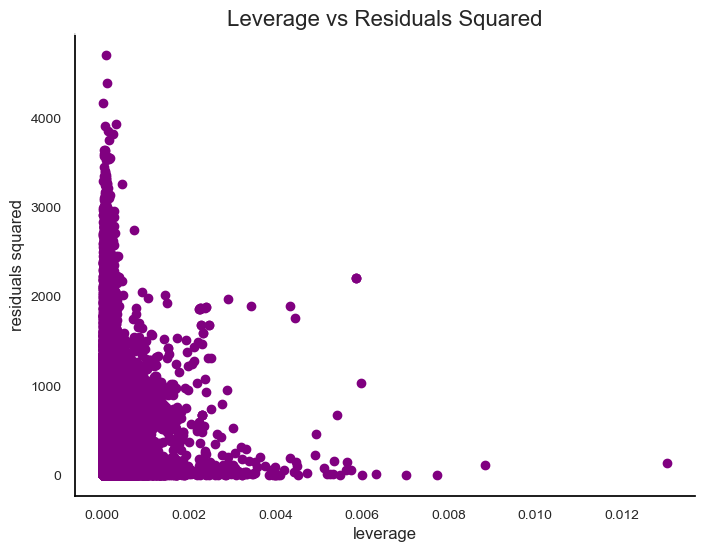

In [38]:
#Going to plot the leverage vs the residuals to determine if there are any outliers
# plot the leverage vs. the square of the residual

i = thirdModel.get_influence()
#Get the diagonal elements which is the leverage
leverage = i.hat_matrix_diag

#Then get residuals
residuals = thirdModel.resid

#Then take the square of the residuals
residualsSquared = residuals**2

#Create a plot
plt.figure(figsize=(8,6))
plt.scatter(leverage, residualsSquared, color='purple')
plt.xlabel('leverage', fontsize=12)
plt.ylabel('residuals squared', fontsize=12)
plt.title('Leverage vs Residuals Squared', fontsize=16)
plt.grid(False)
ax=plt.gca()
ax.set_facecolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [39]:
highResidualValues = residualsSquared > 2000
highLeverageValues = leverage > 0.003

unusualValues = highResidualValues | highLeverageValues

updatedRegDF4 = Reg_DF.drop (['liveness', 'key', 'mode', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'duration_ms', 'danceability'], axis=1)

cleanUpdatedRegDF4 = updatedRegDF4[~unusualValues]
cleanUpdatedRegDF4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88948 entries, 0 to 113999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    88948 non-null  int64  
 1   energy        88948 non-null  float64
 2   loudness      88948 non-null  float64
 3   acousticness  88948 non-null  float64
 4   genre         88948 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 4.1 MB


In [40]:
editedRegDF4 = cleanUpdatedRegDF4.drop(columns=['popularity'])
editedRegDF4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88948 entries, 0 to 113999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   energy        88948 non-null  float64
 1   loudness      88948 non-null  float64
 2   acousticness  88948 non-null  float64
 3   genre         88948 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 3.4 MB


In [41]:
formula4 = f"popularity ~ {' + '.join(editedRegDF4)} + {' + '.join(updated_interactions2)}"
thirdModel = smf.ols(formula=formula4,data = updatedRegDF4).fit()
thirdModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     373.8
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:50:12   Log-Likelihood:            -3.9691e+05
No. Observations:               89741   AIC:                         7.939e+05
Df Residuals:                   89730   BIC:                         7.940e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                72.6437      1.072     67.788      0.000      70.543      74.744
energy                  -38.7567      1.100    -35.227      0.000     -40.913     -36.600
loudness                  1.6272      0.071     22.895      0.000       1.488       1.767
acousticness            -31.3159      1.279    -24.494      0.000     -33.822     -28.810
genre                    -0.2395      0.013    -17.910      0.000      -0.266      -0.213
energy:loudness           0.5149      0.072      7.144      0.000       0.374       0.656
energy:acousticness      40.2543      1.229     32.747      0.000      37.845      42.664
energy:genre              0.2981      0.014     21.692      0.000       0.271       0.325
loudness:acousticness    -1.1284      0.071    -15.924      0.000      -1.267      -0.990
loudness:genre           -0.0130      0.001    -23.838      0.000      -0.014      -0.012
acousticness:genre       -0.0949      0.008    -11.224      0.000      -0.111      -0.078
==============================================================================
Omnibus:                     3090.658   Durbin-Watson:                   0.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1406.931
Skew:                           0.023   Prob(JB):                    3.08e-306
Kurtosis:                       2.388   Cond. No.                     1.93e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the multiple models it becomes clear is no singular feature that is a good predictor for song popularity. The R-squared values remain low for all models regardless if it is linear or multi-linear. Thus, indicating there is no linear or multi-linear relationship prevalent in the data.

## Decision Trees and KNN

Next, I am going to run a decision tree and KNN to determine if a decision tree model and KNN model can predict if a song is popular or not based on genre. Since, song popularity is rated from 0 to 100 I will classify a song is popular at a level of 50

### Precision and Recall Functions for KNN and Decision Trees

In [61]:
def calculate_precision(y_true, y_pred, pos_label_value=1.0):
    
    truePos=0
    falsePos=0
    
    for i in range(len(y_pred)):
        if y_true[i]==pos_label_value and y_pred[i]==pos_label_value:
            truePos +=1
            
        if y_pred[i]==pos_label_value and y_true[i] != pos_label_value:
            falsePos += 1
            
    return truePos/(truePos+falsePos)

def calculate_recall(y_true, y_pred, pos_label_value=1.0):
    
    truePos=0
    falseNeg=0
    
    
    for i in range(len(y_pred)):
        if y_true[i]==pos_label_value and y_pred[i]==pos_label_value:
            truePos +=1
            
        if y_pred[i] != pos_label_value and y_true[i] == pos_label_value:
            falseNeg += 1
        
    
    return truePos/(truePos+falseNeg)

### Decision Tree

In [62]:
KNN_DT_DF

popular  genre
0             1      0
1             1      0
2             1      0
3             1      0
4             1      0
...         ...    ...
113995        0    112
113996        0    112
113997        0    112
113998        0    112
113999        0    112

[89741 rows x 2 columns]

In [63]:
X_DT_KNN = KNN_DT_DF.drop('popular', axis=1)
y_DT_KNN = KNN_DT_DF['popular']

Xtrain, Xtest, ytrain, ytest = train_test_split(X_DT_KNN,y_DT_KNN, test_size = 0.20, random_state=42)

In [83]:
def build_dt(data_X, data_y, max_depth = None, max_leaf_nodes =None):
    
    decisionTree = DecisionTreeClassifier(random_state=42, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
        
    decisionTree.fit(data_X, data_y)
    return decisionTree

Model Precision : 0.62
Model Recall : 0.41
Model Accuracy : 0.81


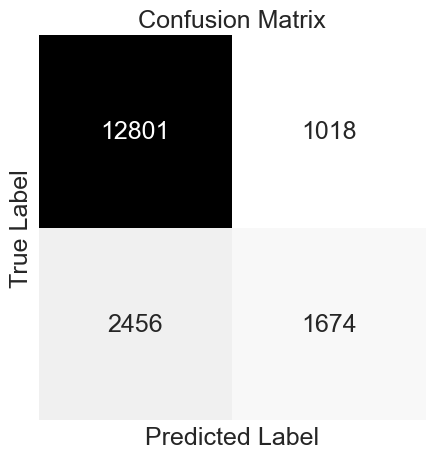

In [84]:
DecisionTree = build_dt(Xtrain, ytrain)
yPred = DecisionTree.predict(Xtest)
yTrue = ytest.tolist()

precision = calculate_precision(yTrue, yPred,1.0)
recall = calculate_recall(yTrue, yPred, 1.0)
accuracy = accuracy_score(yTrue,yPred)

print('Model Precision : %0.2f' % precision)
print('Model Recall : %0.2f' % recall)
print('Model Accuracy : %0.2f' % accuracy)
confusionMatrix = confusion_matrix(yTrue, yPred)

plt.figure(figsize=(5,5))

sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Greys', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([])
plt.yticks([])
plt.show()



### KNN

In [95]:
def build_KNN(data_X, data_y, neighbors):
    
    KNN = KNeighborsClassifier(n_neighbors=neighbors)
        
    KNN.fit(data_X, data_y)
    return KNN
    

In [120]:
acc = []
allks = [1,5,10,25,75,100,150,200,250,300,350,400,450,500,1000]
yTrue = ytest.tolist()

# your code here

from sklearn.metrics import accuracy_score

for ks in allks:
    knn = build_KNN(Xtrain, ytrain, ks)
    yhat = knn.predict(Xtest)
    accuracy = accuracy_score(yTrue,yhat)
    acc.append(accuracy)
    #print(accuracy)


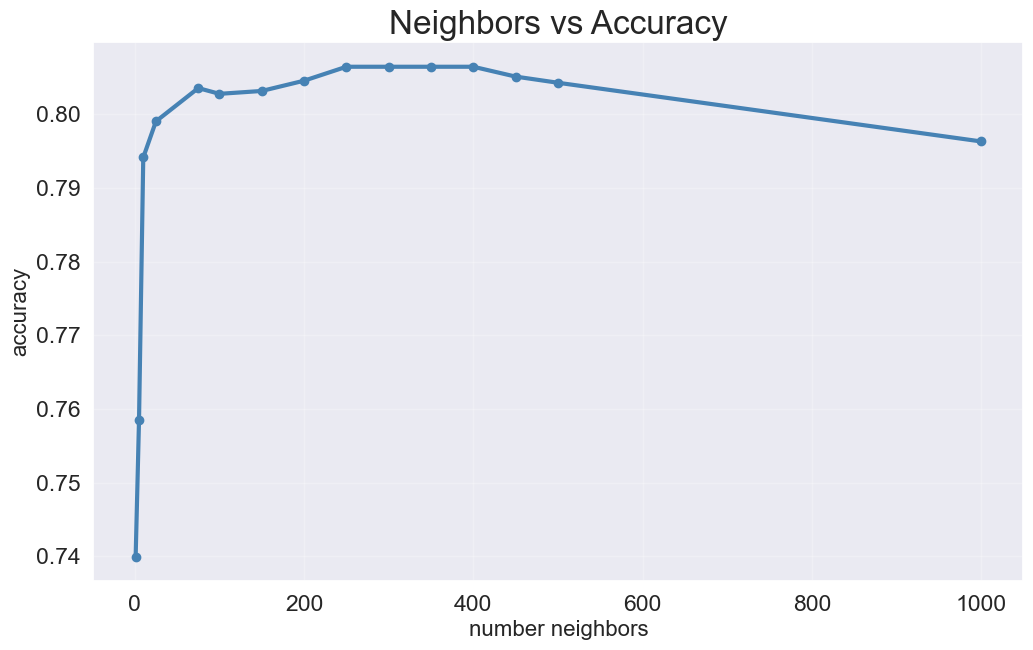

In [121]:
# you can use this code to create your plot    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.title('Neighbors vs Accuracy', fontsize=24)
ax.grid(alpha=0.25)
plt.show()

Model Precision : 0.62
Model Recall : 0.41
Model Accuracy : 0.81


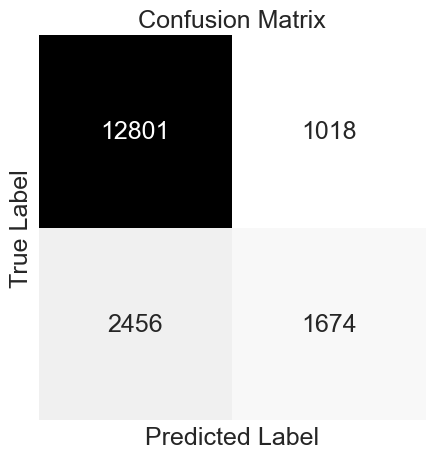

In [122]:
KNN = build_KNN(Xtrain, ytrain,250)
yPreds = KNN.predict(Xtest)

precision = calculate_precision(yTrue, yPreds,1.0)
recall = calculate_recall(yTrue, yPreds, 1.0)
accuracy = accuracy_score(yTrue,yPreds)

print('Model Precision : %0.2f' % precision)
print('Model Recall : %0.2f' % recall)
print('Model Accuracy : %0.2f' % accuracy)
confusionMatrix = confusion_matrix(yTrue, yPreds)

plt.figure(figsize=(5,5))

sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Greys', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([])
plt.yticks([])
plt.show()

### GridSearch CV for Decision Tree

In [123]:
#GridSearch for Decision Tree

grid = {
    'max_depth': [3, 5, 10, None],
    'max_leaf_nodes': [5, 10, 20, 30, None]
}

gridSearchDT = GridSearchCV(DecisionTree, grid, cv=5, scoring='accuracy')

gridSearchDT.fit(Xtrain, ytrain)

print('Best Parameters', gridSearchDT.best_params_)

Best Parameters {'max_depth': None, 'max_leaf_nodes': None}
